# Проект: вариант 1
    
####    Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

 1) В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
 
 2) Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.

 3) Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

## Задание 1
 В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.

In [1]:
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

%matplotlib inline

Откроем файлы и посмотрим на типы данных, пропущенные значения, размеры датафреймов и уникальные значения

In [2]:
reg_df = pd.read_csv("/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-shajkovskij/shared/problem1-reg_data.csv", sep=';')
reg_df

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5
...,...,...
999995,1600874034,1110618
999996,1600874086,1110619
999997,1600874139,1110620
999998,1600874191,1110621


In [3]:
reg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


In [4]:
reg_df.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [5]:
reg_df.describe()

,reg_ts,uid
count,1.000000e+06,1.000000e+06
mean,1.548332e+09,5.552354e+05
std,5.253653e+07,3.206011e+05
min,9.113822e+08,1.000000e+00
25%,1.528034e+09,2.776438e+05
50%,1.564454e+09,5.550455e+05
75%,1.585759e+09,8.329712e+05
max,1.600874e+09,1.110622e+06


In [6]:
reg_df.nunique()

reg_ts    1000000
uid       1000000
dtype: int64

In [7]:
auth_df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-shajkovskij/shared/problem1-auth_data.csv',sep=';')
auth_df

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2
...,...,...
9601008,1600874034,1110618
9601009,1600874086,1110619
9601010,1600874139,1110620
9601011,1600874191,1110621


In [8]:
auth_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


In [9]:
auth_df.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [10]:
auth_df.describe()

,auth_ts,uid
count,9.601013e+06,9.601013e+06
mean,1.548778e+09,3.347198e+05
std,5.160527e+07,2.832669e+05
min,9.113822e+08,1.000000e+00
25%,1.528375e+09,9.599700e+04
50%,1.564577e+09,2.579210e+05
75%,1.585823e+09,5.190250e+05
max,1.600874e+09,1.110622e+06


In [11]:
auth_df.nunique()

auth_ts    9180915
uid        1000000
dtype: int64

кол-во уникальных uid одинаково

#### Напишем функцию, которая рассчитывает Retention N-ого дня по каждой когорте (дате регистрации пользователя)

- reg - Датафрейм с данными о регистрации пользователей в игре
- auth - Датафрейм с данными о входе пользователей в игру
- start_date - Дата первой когорты
- end_date - Дата последней когорты
- retention_days - Дни за которые рассматриваем retention

In [12]:
def retention(reg, auth, start_date=None, end_date=None):
     
    # Создаем колонки даты регистрации и даты входа

    reg['reg_date'] = pd.to_datetime(reg_df['reg_ts'], unit='s').dt.date
    auth['auth_date'] = pd.to_datetime(auth_df['auth_ts'], unit='s').dt.date
    
    # Отбираем диапазон, который задается в функции
    reg = reg.query('reg_date >= @start_date')
    auth = auth.query('auth_date <= @end_date')

    # Мерджим таблицы в один датафрейм
    full_df = auth.merge(reg, on='uid')
    
    # Считаем количество дней с момента регистрации до захода в игру
    full_df['retention_days'] = (full_df.auth_date - full_df.reg_date).dt.days + 1
    
    # Разбиваем на когорты и считаем retention
    cohorts = full_df.groupby(['reg_date', 'retention_days']) \
                     .agg({'uid': 'nunique'}) \
                     .reset_index()
    cohorts_pivot = cohorts.pivot(index='reg_date', columns='retention_days', values='uid')
    retention = cohorts_pivot.divide(cohorts_pivot[1], axis=0).round(3)
    
    # Визуализируем полученные данные
    plt.figure(figsize=(15, 10))
    plt.title('Retention', fontsize=15)
    sns.heatmap(data=retention, annot=True, fmt='.0%', vmin=0.0, vmax=0.1, cmap='crest')
    plt.show()

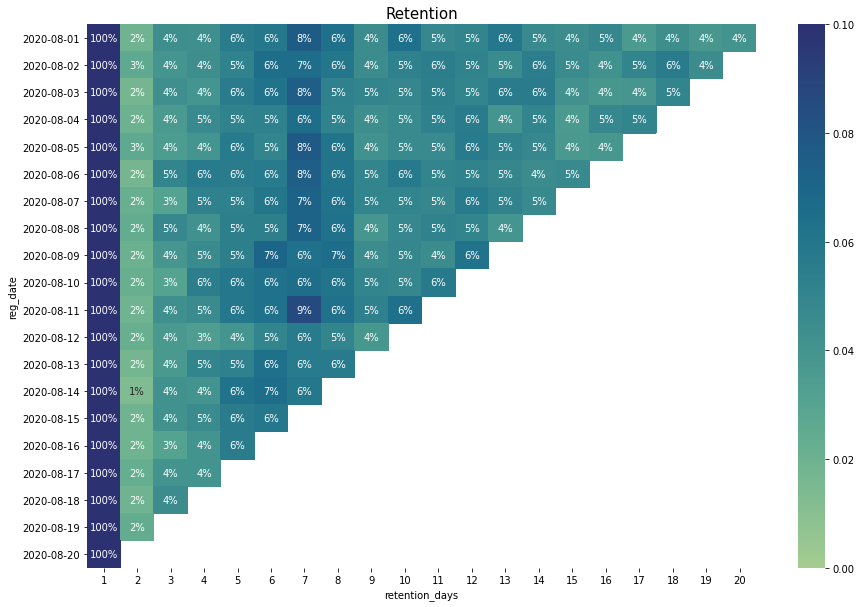

In [13]:
# рекомендуется указывать не более 20 дней, чтобы поулчить читаемый график на выходе
retention(reg_df, auth_df, start_date=datetime.date(2020, 8, 1), end_date=datetime.date(2020, 8, 20))

## Задание 2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

Считываем данные

In [14]:
df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-shajkovskij/15_07/Final/Проект_1_Задание_2.csv', sep=';')
df

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


Проверяем тип переменных и прощуенные значения

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [16]:
df.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

Отсортируем a b тесты

In [17]:
A_test = df.query('testgroup == "a"')
B_test = df.query('testgroup == "b"')

Отберем 3 датафрейма: контрольный, тестовый и общий, где значение revenue больше 0

In [18]:
control = A_test.query('revenue > 0')
test = B_test.query('revenue > 0')
df_revenue = df.query('revenue > 0')

In [19]:
control

,user_id,revenue,testgroup
72,73,351,a
341,342,290,a
385,386,250,a
416,417,37324,a
712,713,255,a
...,...,...,...
404304,404305,360,a
404315,404316,262,a
404543,404544,369,a
404602,404603,251,a


In [20]:
test

,user_id,revenue,testgroup
160,161,3797,b
377,378,3768,b
386,387,3527,b
551,552,2038,b
913,914,3902,b
...,...,...,...
403843,403844,3383,b
403994,403995,2793,b
404161,404162,2316,b
404193,404194,2998,b


In [21]:
df_revenue

,user_id,revenue,testgroup
72,73,351,a
160,161,3797,b
341,342,290,a
377,378,3768,b
385,386,250,a
...,...,...,...
404315,404316,262,a
404525,404526,3120,b
404543,404544,369,a
404602,404603,251,a


 Теперь посмотрим на распределение чеков в тестовой группе а и b

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Control')

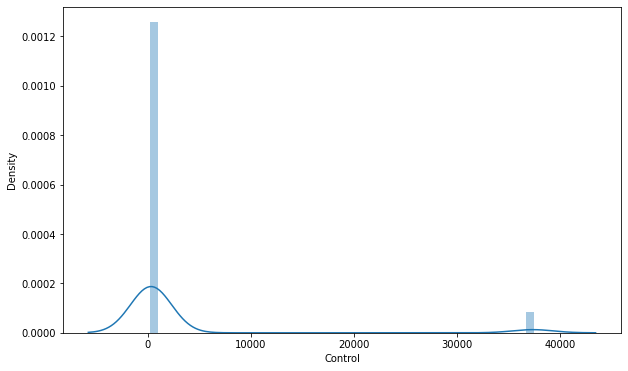

In [22]:
plt.figure(figsize=(10, 6))
sns.distplot(control.revenue)
plt.xlabel('Control')

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Test')

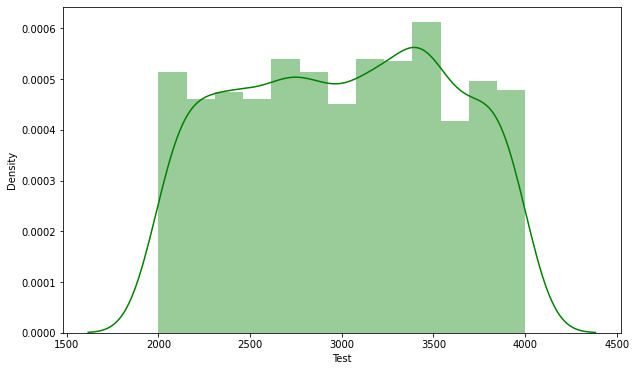

In [23]:
plt.figure(figsize=(10, 6))
sns.distplot(test.revenue, color='Green')
plt.xlabel('Test')

Распределение в контрольной группе, судя по графику, не является нормальным.   Распределение в тестовой группе похоже на нормальное. Посмотрим на такие метрики, как среднее значение, медиану, конверсию, ARPU и ARPPU

In [24]:
metrics = pd.DataFrame(columns=['test', 'control'])

#Mean    
test_mean = test.revenue.mean()
control_mean = control.revenue.mean()
metrics = metrics.append({'test':test_mean,'control':control_mean}, ignore_index=True)

#Median
test_median = np.median(test['revenue'])
control_median = np.median(control['revenue'])
metrics = metrics.append({'test':test_median,'control':control_median}, ignore_index=True)

#Conversion
test_conv = (test.shape[0]/B_test.shape[0])*100
control_conv = (control.shape[0]/A_test.shape[0])*100
metrics = metrics.append({'test':test_conv,'control':control_conv}, ignore_index=True)

#ARPU
test_arpu = B_test.revenue.sum()/B_test.shape[0]
control_arpu = A_test.revenue.sum()/A_test.shape[0]
metrics = metrics.append({'test':test_arpu,'control':control_arpu}, ignore_index=True)

#ARPPU
test_arppu = test.revenue.sum()/test.shape[0]
control_arppu = control.revenue.sum()/control.shape[0]
metrics = metrics.append({'test':test_arppu,'control':control_arppu}, ignore_index=True) 

my_index = ['Mean', 'Median', 'Conversion', 'ARPU', 'ARPPU']
metrics.index = my_index

metrics.apply(lambda x : round(x, 2))

,test,control
Mean,3003.66,2664.00
Median,3022.00,311.00
Conversion,0.89,0.95
ARPU,26.75,25.41
ARPPU,3003.66,2664.00


 Так как в контрольной группе есть заметные выбросы, буду использовать U-критерий Манна-Уитни, который менее чувствителен к выбросам

In [25]:
stats.mannwhitneyu(control.revenue, test.revenue)

MannwhitneyuResult(statistic=222015.0, pvalue=0.0)

Вывод по U-критерий Манна-Уитни:p-value < 0.05, следовательно отклоняем нулевую гипотезу о равенстве распределений. Подтверждаем значимость различий тестовой группы и контрольной. 
 
Проверим данные с помощью bootstrap

In [26]:
 def get_bootstrap(
    test, 
    control, 
    boot_it = 1000, 
    statistic = np.mean, 
    bootstrap_conf_level = 0.95 
):
    boot_len = max([len(test), len(control)])
    boot_data = []
    
    for i in range(boot_it): 
        samples_1 = test.sample(boot_len, replace = True ).values
        samples_2 = control.sample(boot_len, replace = True).values
        boot_data.append(statistic(samples_1-samples_2)) 
        
    pd_boot_data = pd.DataFrame(boot_data)
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
    p_1 = stats.norm.cdf(x = 0, loc = np.mean(boot_data), scale = np.std(boot_data))
    p_2 = stats.norm.cdf(x = 0, loc = -np.mean(boot_data), scale = np.std(boot_data))
    p_value = min(p_1, p_2) * 2
    
    plt.hist(pd_boot_data[0], bins = 50)
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
              
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

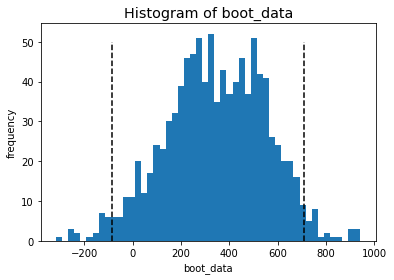

In [27]:
bootstrap_test1 = get_bootstrap(test.revenue, control.revenue, statistic=np.mean)

In [28]:
bootstrap_test1['p_value']

0.09250634546532227

In [29]:
bootstrap_test1['ci']

,0
0.025,-85.081522
0.975,711.063356


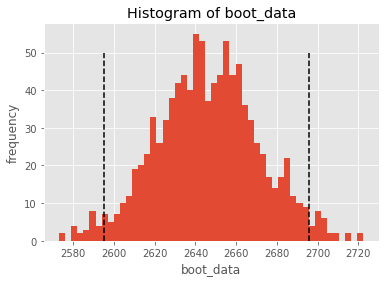

In [30]:
bootstrap_test2 = get_bootstrap(test.revenue, control.revenue, statistic=np.median)

In [31]:
bootstrap_test2['p_value']

0.0

In [32]:
 bootstrap_test2['ci']

,0
0.025,2594.9875
0.975,2696.0125


#### Общий вывод:   
- Контрольная выборка имеет большие выбросы, что достаточно сильно искажает среднее значение.    
- U-тест Манна-Уитни показал статистически значимые различия p-value < 0.05.   
- Применяя бутстрап с оценкой среднего, можно было бы принять нулевую гипотезу о равенстве средних и сделать вывод, что тестовая и контрольная выборки одинаковы. Однако, после применения того же бутстрап, но уже по медиане дает нам отклонить нулевую гипотезу, так как p-value сильно меньше 0.05.   

#### Итог: 
 Считаю, что нет смысла на данный момент выкатывать обновление, необходимо проанализировать контрольную группу, понять почему существует такое различие в оплате клиентов и только после этого можно принимать решение.

## Задание № 3 
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как? Метрики, необходимые для оценки результатов последнего пршедшего события:

 Метрики проведения тематических событий:


- Воронка прохождения уровней. Воронка покажет конверсию между шагами (отношение пользователей на шаге N к пользователям на шаге N-1), позволяет выявить узкие места мероприятий, где эта конверсия падает сильнее, чем на других шагах, то есть в каком месте происходит самый большой отток пользователей;
- Retention. Посмотреть в динамике, возможно проведением события мы повлияем на активность пользователей в последующие периода (пичем повлиять можем как в большую сторону, так и в меньшую);
- DAU - число уникальных пользователей в день. Сравним в динамике. Возможно, наше событие привлечет аудиторию, если мы не забудем их уведомить о мероприятии (пуши, сообщение и т.д.);
- WAU  - аналогично с предыдущей метрикой, можно проанализировать изменится ли показатель после проведения мероприятий;
- Users online(CCU Concurrent users) - количество активных пользователей.
- И PCCU (Peak Concurrent Users) – максимальное количество пользователей, одновременно находящихся в приложении. Пользователей можно просегмениторовать на тех, кто участвует в мероприятии и нет, возможно прирост нецелевой (пользователи не участвуют в мероприятии).Если мероприятие краткосрочное и проводится одновременно для всех пользователей и наше приложении пользуется спросом во всем мире. Следует учесть часовые пояса в сегментации (Япония и центр.часть РФ активность пользователей разная в одно и тоже время из-за разных часовых поясов);
- Средняя продолжительность сессии (Average Session Length). Изменится ли средняя продолжительность сессии при проведении мероприятий. Помимо расчета времени, проведенного в продукте, можно накладывать на него различные действия, совершаемые пользователем, чтобы узнать:
  - сколько времени игроку требуется, чтобы пройти N уровней;
  - сколько времени он потратил на прохождение того или иного уровня;
  - сколько часов провел пользователь в приложении перед тем как уйти
- Общая статистика: среднее количество пройденных пользователями уровней, количество полученных монет/бонусов.

После усложнения можно использовать те же метрики и добавить эти:

- Churn Rate – это показатель оттока пользователей. Интересно, повлияет ли level down (второй вид мероприятия) на отток пользователей. Можно также выделить тех, кто участвовал в мероприятии, на каком этапе была завершена игра, возможно это даст точку роста;
- Корреляцию показателей level down и завершения игры пользователями;
- Корреляцию показателей level down и длительность сессии;
- Посмотреть чем отличаются пользователи п.2 и п.3. Возможно, это даст какие-то идеи для развития продукта.